In [15]:
### What it does: generates plots seen in Figure 1 C, D and B 
## Last modification: 2025/04/16
## input: whippet comparison output diff file (pre-converted into csv), gtf file
## output: csv file with all dPSI (delta Percent Spliced In) values with gene_name and exon number, 
##         csv file with significantly altered dPSI values, plots 


In [16]:
#load packages:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import numpy as np
import re

In [17]:
## define paths
data = "/path/to/whippet/output/data/"
results = "/path/to/store/result/tables/"
figures = "/path/to/store/output/plots/"
files = "/path/to/gtf/file/"

In [18]:
#before, open whippet out.diff for instance in excel and convert to csv
#load input files and data
df= pd.read_csv(data + 'ctr_vs_eif_kd.csv')
gtf_file = files+'gencode.v44.basic.annotation.gtf'

In [19]:
#rename columns according to what was A and B in the whippet comparison
df.rename(columns={'Psi_A': 'psi_ctrl', 'Psi_B': 'psi_KD'}, inplace=True)

#select for cassette exons 
ce = df[df['Type'] == 'CE']

# OPTIONAL: add column for dPSI if KD was B and control was A in whippet comparison (depending on which way
## around you want to plot; ctr - KD or KD - ctr)
ce['dPSI'] = ce['psi_KD'] - ce['psi_ctrl']

/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_15878/592016022.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce['dPSI'] = ce['psi_KD'] - ce['psi_ctrl']


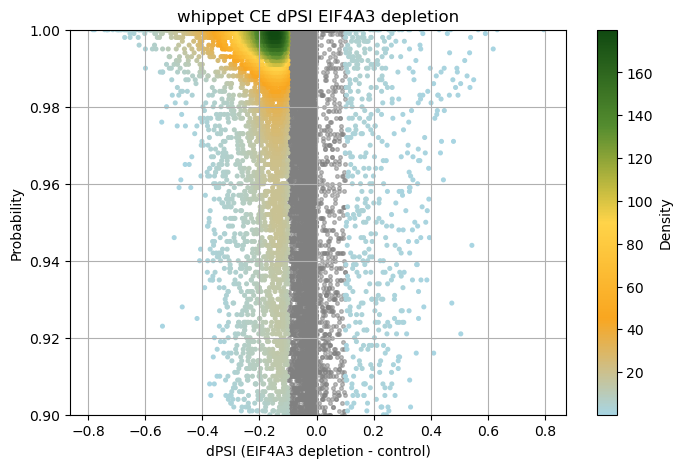

In [20]:
### ---VOLCANO PLOT FOR dPSI versus PROBABILITY-----

# Make a volcano plot for dPSI versus probability. Whippet authors recommend a cutoff of a Probability of 0.9.
# As a significance treshold for the dPSI we use +/- 0.1 (10%).

# Define custom colors
custom_colors = ["#A8D5E2", "#F9A620", "#FFD449", "#548C2F", "#104911"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

# Define conditions for skipping and inclusion
skipping_condition = (ce['dPSI'] <= -0.1) & (ce['Probability'] >= 0.9)
inclusion_condition = (ce['dPSI'] >= 0.1) & (ce['Probability'] >= 0.9)

# Compute density only for highlighted points
highlighted = ce.loc[skipping_condition | inclusion_condition]
xy_highlighted = np.vstack([highlighted['dPSI'], highlighted['Probability']])
density_highlighted = gaussian_kde(xy_highlighted)(xy_highlighted)

# Normalize density values for better color mapping
norm = mcolors.Normalize(vmin=density_highlighted.min(), vmax=density_highlighted.max())

# Sort highlighted points by density for better visualization
sorted_indices = density_highlighted.argsort()
highlighted_sorted = highlighted.iloc[sorted_indices]
density_sorted = density_highlighted[sorted_indices]

# Create figure and grid spec for zoomed y-axis
fig, ax = plt.subplots(figsize=(8, 5))

# Main scatter plot (non-highlighted points in gray)
ax.scatter(ce.loc[~(skipping_condition | inclusion_condition), 'dPSI'], 
           ce.loc[~(skipping_condition | inclusion_condition), 'Probability'], 
           s=7, color='gray', alpha=0.5)

# Highlighted points with density coloring
sc = ax.scatter(highlighted_sorted['dPSI'], highlighted_sorted['Probability'], 
                c=density_sorted, s=7, cmap=custom_cmap, norm=norm)

# Colorbar with density mapping
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Density')

# Split y-axis (zoom in on 0.9 - 1.0 range)
ax.set_ylim(0.9, 1.0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))

# Customize plot
ax.set_xlabel('dPSI (EIF4A3 depletion - control)')
ax.set_ylabel('Probability')
ax.set_title('whippet CE dPSI EIF4A3 depletion')
ax.grid(True)

# # Save figures
plt.savefig(figures+'density_plot_CE_whippet_SRS_mRNA_eif4a3_depletion.pdf')

plt.show()


In [20]:
### -------ASSIGN EXON NUMBERS AND GENE NAMES TO THE DATAFRAME-----

## Exon numbers are assigned according to the most abundant isoform (tsl 1). If a given exon (Coord)
## is not in tsl_1, numbering is according to any other transcript that includes the exon coordinate. 

# Function to parse GTF file and get exon numbering for the most abundant isoform 
def parse_gtf(gtf_file):
    # Load the GTF file
    gtf_df = pd.read_csv(gtf_file, sep='\t', comment='#', header=None, names=[
        'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    
    # Filter for exons
    gtf_df = gtf_df[gtf_df['feature'] == 'exon']
    
    # Extract relevant fields from the attributes column
    gtf_df['exon_number'] = gtf_df['attribute'].str.extract(r'exon_number (\d+);').astype(float)
    gtf_df['gene_name'] = gtf_df['attribute'].str.extract(r'gene_name "([^"]+)"')
    gtf_df['transcript_id'] = gtf_df['attribute'].str.extract(r'transcript_id "([^"]+)"')
    gtf_df['transcript_support_level'] = gtf_df['attribute'].str.extract(r'transcript_support_level "([^"]+)"')

    return gtf_df[['seqname', 'start', 'end', 'exon_number', 'gene_name', 'transcript_id', 'transcript_support_level']]

# Function to get exon info with fallback to all transcripts if no match is found in TSL=1
def get_exon_info(chromosome, start, end, gtf_df):
    # Filter for TSL=1 transcripts
    tsl1_exons = gtf_df[gtf_df['transcript_support_level'] == "1"]
    
    # Look for a match in TSL=1 subset
    matching_exon = tsl1_exons[
        (tsl1_exons['seqname'] == chromosome) &
        (tsl1_exons['start'] <= start) &
        (tsl1_exons['end'] >= end)
    ]
    
    if not matching_exon.empty:
        # Match found in TSL=1 subset
        return matching_exon.iloc[0]['exon_number'], matching_exon.iloc[0]['gene_name']
    else:
        # Fallback to all transcripts if no match in TSL=1
        matching_exon = gtf_df[
            (gtf_df['seqname'] == chromosome) &
            (gtf_df['start'] <= start) &
            (gtf_df['end'] >= end)
        ]
        if not matching_exon.empty:
            return matching_exon.iloc[0]['exon_number'], matching_exon.iloc[0]['gene_name']
    return None, None


In [21]:
# Read the GTF file and parse it
gtf_df = parse_gtf(gtf_file)

In [22]:
# Add exon_number and gene_name to DataFrame based on Coord
exon_numbers = []
gene_names = []
for coord in ce['Coord']:
    match = re.match(r'(chr[^\:]+):(\d+)-(\d+)', coord)
    if match:
        chromosome = match.group(1)
        start = int(match.group(2))
        end = int(match.group(3))
        exon_number, gene_name = get_exon_info(chromosome, start, end, gtf_df)
        exon_numbers.append(exon_number)
        gene_names.append(gene_name)
    else:
        exon_numbers.append(None)
        gene_names.append(None)

ce['exon_number'] = exon_numbers
ce['gene_name'] = gene_names

/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_22836/956825876.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce['exon_number'] = exon_numbers
/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_22836/956825876.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce['gene_name'] = gene_names


In [23]:
ce.to_csv(results+'whippet_CE_gene_name_exon_number.csv', index=False)

In [24]:
#### ------SUBSAMPLE SIGNIFICANTLY ALTERED EXONS----- #####

# filter dataframe based on Probability greater/equal 0.9 and dPSI min 10%
ce_fil = ce[(ce['Probability'] >= 0.9) & ((ce['dPSI'] >= 0.1) | (ce['dPSI'] <= -0.1))]

In [25]:
# Count the number of unique gene names in the ce_fil DataFrame
unique_gene_count = ce_fil['Gene'].nunique()

print(f'The number of unique gene names in ce_fil: {unique_gene_count}')


The number of unique gene names in ce_fil: 3011


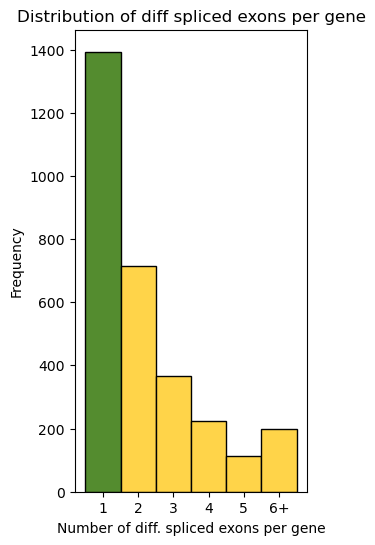

In [34]:
## ---HISTOGRAM NUMBER OF diffSPLICE EXONS PER GENE------ #####

# Define custom colors
custom_colors = ["#A8D5E2", "#F9A620", "#FFD449", "#548C2F", "#104911"]

# Group by 'gene_name' and count the number of 'Coord'
frequency = ce_fil.groupby('Gene')['Coord'].count()

# Modify frequency data: Group 6+ into one category
frequency_clipped = np.where(frequency >= 6, 6, frequency)  # Replace all values >=6 with 6

# Define bin edges (ensure 6+ is treated as one bin)
bin_edges = np.arange(0.5, 7.5, 1)  # Bins from 0-6, where 6+ is grouped

# Create figure
plt.figure(figsize=(3,6))

# Assign colors: 
colors = [custom_colors[3] if x < 1 else custom_colors[2] for x in range(7)]  

# Histogram plot with custom colors per bar
n, bins, patches = plt.hist(frequency_clipped, bins=bin_edges, edgecolor='black', align='mid')

# Apply colors to each bar
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

# X-axis adjustments
plt.xticks([1, 2, 3, 4, 5, 6], ['1', '2', '3', '4', '5', '6+'])  # Label 6+ correctly

# Labels & Title
plt.xlabel('Differentially spliced exons per gene')
plt.ylabel('Number of genes')
plt.title('Distribution of diff spliced exons per gene')

# # Save figure
plt.savefig(figures+'diffSpli_exons_per_gene_histo.pdf')

plt.show()


In [43]:
## ADD THE diffSplice EXON COUNT TO DATAFRAME ###

# Count the number of 'Coord' per 'gene_name'
frequency = ce_fil.groupby('gene_name')['Coord'].count()
ce_fil['dPSI_exons_per_gene'] = ce_fil['gene_name'].map(frequency)


/var/folders/s5/012b_sqx2bl9vk20cyklfj_r0000gn/T/ipykernel_22836/3293748173.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ce_fil['dPSI_exons_per_gene'] = ce_fil['gene_name'].map(frequency)


In [45]:
ce_fil.to_csv(results+'sig_whip_CE_prob0.9_dPSI_0.1.csv', index=False)

In [6]:
## PLOT DIFFERENT SPLICE TYPES
unique_types = df['Type'].unique()

# Display the unique values
print("Unique values in the 'Type' column:")
print(unique_types)


Unique values in the 'Type' column:
['CE' 'AF' 'TE' 'TS' 'AA' 'AD' 'RI' 'AL']


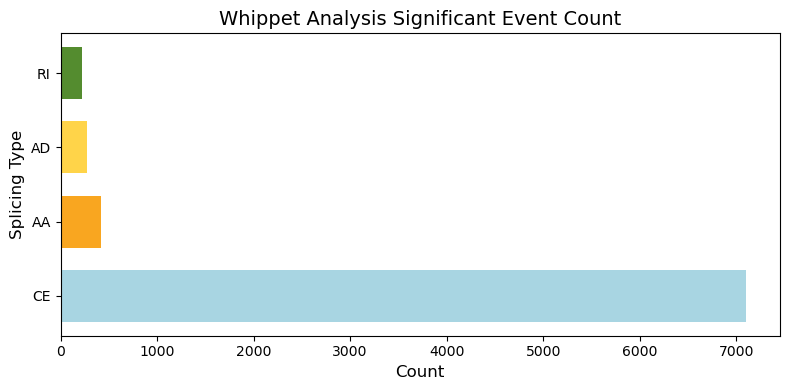

In [14]:
# Filter the DataFrame based on conditions
filtered_df = df[
    ((df['DeltaPsi'] < -0.1) | (df['DeltaPsi'] > 0.1)) & (df['Probability'] >= 0.9)
]

# Count the number of entries for each Type (CE, RI, AD, AA)
type_counts = filtered_df['Type'].value_counts()

# Select only the relevant types
relevant_types = ['CE', 'RI', 'AD', 'AA']
type_counts = type_counts[type_counts.index.isin(relevant_types)]

# Define custom colors
custom_colors = ["#A8D5E2", "#F9A620", "#FFD449", "#548C2F"]

# Create the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(type_counts.index, type_counts.values, color=custom_colors[:len(type_counts)], height=0.7)

# Set labels and title
plt.xlabel('Altered splicing event count', fontsize=12)
plt.ylabel('Splicing Type', fontsize=12)
plt.title('Whippet Analysis Significant Event Count', fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()

# Save and show the plot
plt.savefig(figures + "AS_categories_whippet_output.pdf")
plt.show()
